In [1]:
from runner import *

loading complete, calculating accuracy
getting human labeled boundaries
complete


In [1]:
import importlib
importlib.reload(plt)
importlib.reload(plotting)
plotting.set_dir(plotpath)

NameError: name 'plt' is not defined

In [2]:
image_rect = [0.0, 0.0, somaImage.shape[0], somaImage.shape[1]]
mini_rna = RNA.sample(100000)
qtree, rna_list = trees.convert_to_qtree(RNA, image_rect, 10)
mini_qtree, mini_rna_list = trees.convert_to_qtree(mini_rna, image_rect, 10)

1991684it [02:38, 12543.07it/s]
100000it [00:07, 13221.05it/s]


## Test Search Method

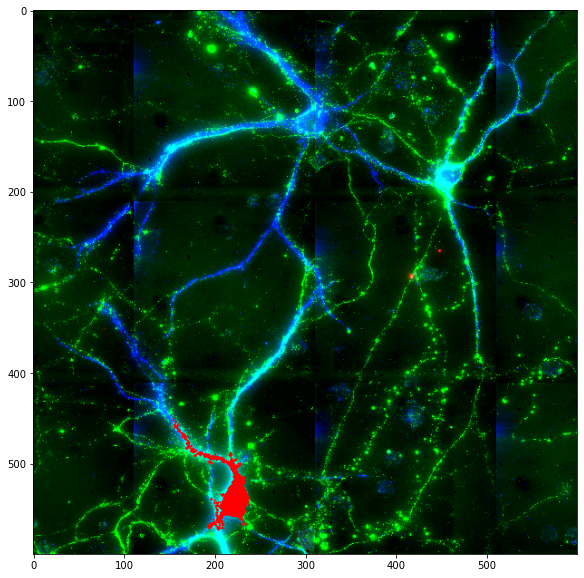

In [16]:
rec_rna = qtree.query(bbox=rec)
start_point = np.random.choice(rec_rna)
searcher = search.PointExplorer(mini_qtree)
search_method = search.RadiusSearch(qtree, 3)
add_method = search.AddMethod()
searcher.start_point(start_point)
searcher.expand(search_method, add_method)

bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h, rec.x:rec.x+rec.w])
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_facecolor('#e6eceb')
basicrna.plot_points(ax, searcher.accepted, image=bgimage, offset=(rec.y, rec.x))
plt.show()

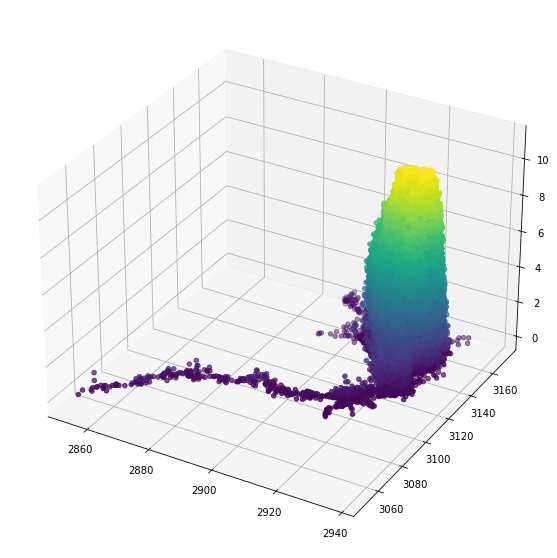

In [17]:
from mpl_toolkits import mplot3d

rna_list = searcher.accepted
ys = [pt.y for pt in rna_list]
xs = [pt.x for pt in rna_list]
zs = [pt.z for pt in rna_list]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xs, ys, zs, c=zs)

plt.show()

## Find High Variance Barcodes

In [18]:
barcodes = Counter(RNA['barcode_id'])
soma_cells = Counter(RNA[RNA['process_index'] == 0]['cell_index'])
process_cells = Counter(RNA[RNA['process_index'] > 0]['cell_index'])

soma_counts = np.zeros(np.max(list(soma_cells.keys())) + 1)
process_counts = np.zeros(np.max(list(soma_cells.keys())) + 1)
barcodes_counts = np.zeros(1240)
for key in barcodes:
    barcodes_counts[key] = barcodes[key]

for key in soma_cells:
    soma_counts[key] = soma_cells[key]

for key in soma_cells:
    process_counts[key] = process_cells[key]

max_soma_cells = np.argsort(soma_counts)[::-1]
max_process_cells = np.argsort(process_counts)[::-1]
max_codes = np.argsort(barcodes_counts)[::-1]
max_codes

array([569, 505, 781, ..., 107, 171, 113], dtype=int64)

## Barcode Qtrees

In [19]:
barcode_qtrees, barcode_rna_lists = trees.generate_barcode_qtrees(rna_list, image_rect)
# fig, ax = plt.subplots()
# barcode_qtrees[540].plot_points(ax)
# plt.show()

12264it [00:00, 191582.50it/s]


## Density Measurements

In [21]:
n = 10000
rna_subset = np.random.choice(rna_list, n, False)

n_neighbors = np.zeros(n)
all_neighbors = [None for _ in range(n)]
type_list = ["unlabeled" for _ in range(n)]
for i, pt in tqdm(enumerate(rna_subset)):
    neighbors = qtree.radius_query((pt.y, pt.x), 5, getter=trees.Getter())
    n_neighbors[i] = len(neighbors)
    all_neighbors[i] = neighbors

    if pt.cell > 0:
        if pt.processIndex > 0:
            type_list[i] = "process"
        else:
            type_list[i] = "soma"

density = n_neighbors/(np.pi * 25)
rna_subset_table = pd.DataFrame({"density" : density,
                                 "type" : type_list,
                                 "barcode" : [point.barcode for point in rna_subset],
                                "cell": [point.cell for point in rna_subset]})

10000it [00:30, 329.33it/s]


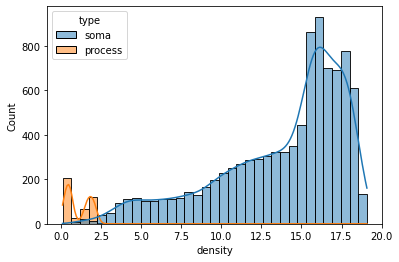

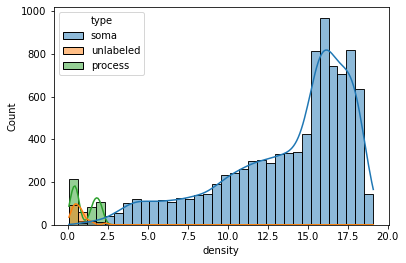

In [22]:
plt.figure()
sns.histplot(rna_subset_table[rna_subset_table["type"] != "unlabeled"], x="density", hue="type", kde=True)
plt.show()
plt.figure()
sns.histplot(rna_subset_table, x="density", hue="type", kde=True)
plt.show()

## Density Change as Distance from Cell

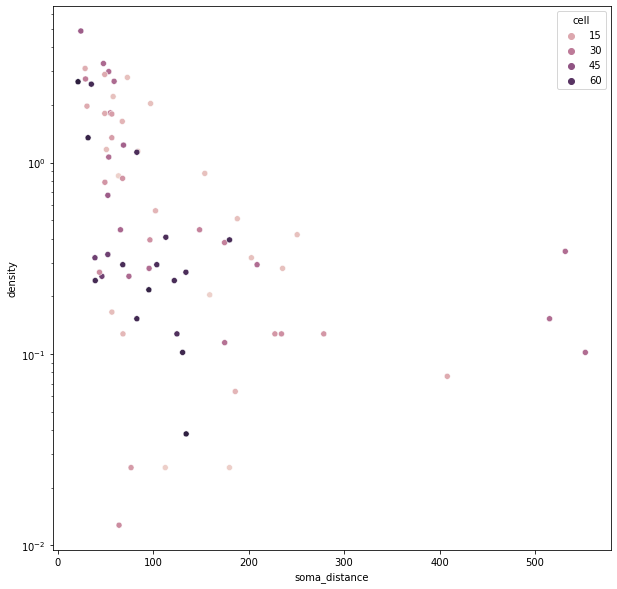

In [12]:
soma_distance = [point.somaDistance for point in rna_subset]
rna_subset_table['soma_distance'] = soma_distance

process_subset = rna_subset_table[rna_subset_table['type']=='process']

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=process_subset[process_subset['barcode'] == 520], y='density', hue='cell', x='soma_distance', ax=ax)
ax.set_yscale('log')
plt.show()

## Gradient Calculations

In [13]:
average_loc = np.zeros((n, 2))
average_delta = np.zeros((n, 2))

for i, pt in tqdm(enumerate(rna_subset)):
    neighbors = all_neighbors[i]
    average_x = np.average([neighbor.x for neighbor in neighbors])
    average_y = np.average([neighbor.y for neighbor in neighbors])
    average_loc[i, :] = [average_y, average_x]
    average_delta[i, :] = [average_y - pt.y, average_x - pt.x]

rna_subset_table["local_delta_x"] = average_delta[:,1]
rna_subset_table["local_delta_y"] = average_delta[:,0]

40000it [00:12, 3271.24it/s]


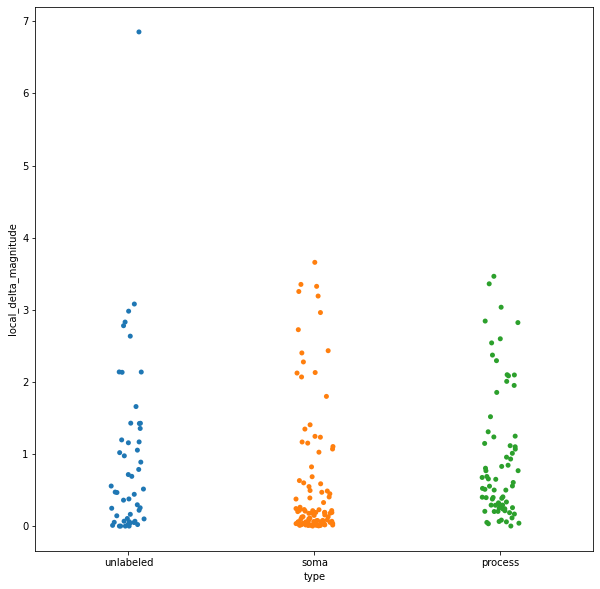

In [14]:
rna_subset_table["local_delta_magnitude"] = (rna_subset_table["local_delta_x"]**2 + rna_subset_table["local_delta_y"]**2)**1/2
fig, ax = plt.subplots(figsize=(10,10))
sns.stripplot(data=rna_subset_table[rna_subset_table["barcode"]==1170], y="local_delta_magnitude", x="type", ax=ax)
# sns.kdeplot(data=rna_subset_table, x="local_delta_magnitude", hue="type", ax=ax)
plt.show()

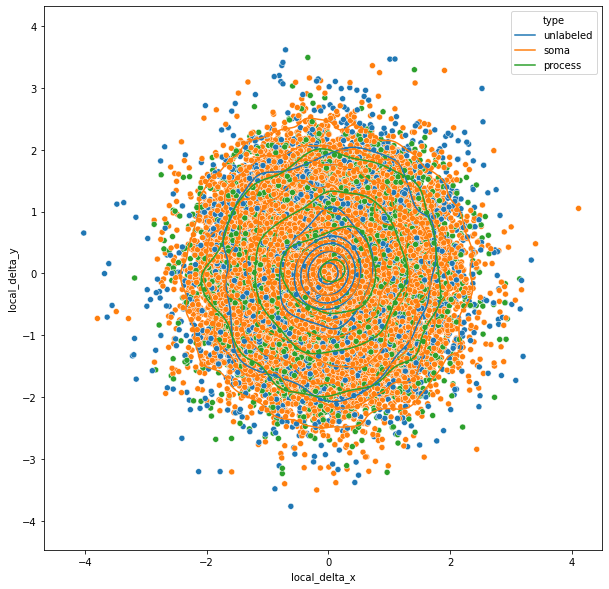

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=rna_subset_table, hue="type", x="local_delta_x", y="local_delta_y", ax=ax)
sns.kdeplot(data=rna_subset_table, hue="type", x="local_delta_x", y="local_delta_y", ax=ax)
plt.show()

## Barcode Density Measurements

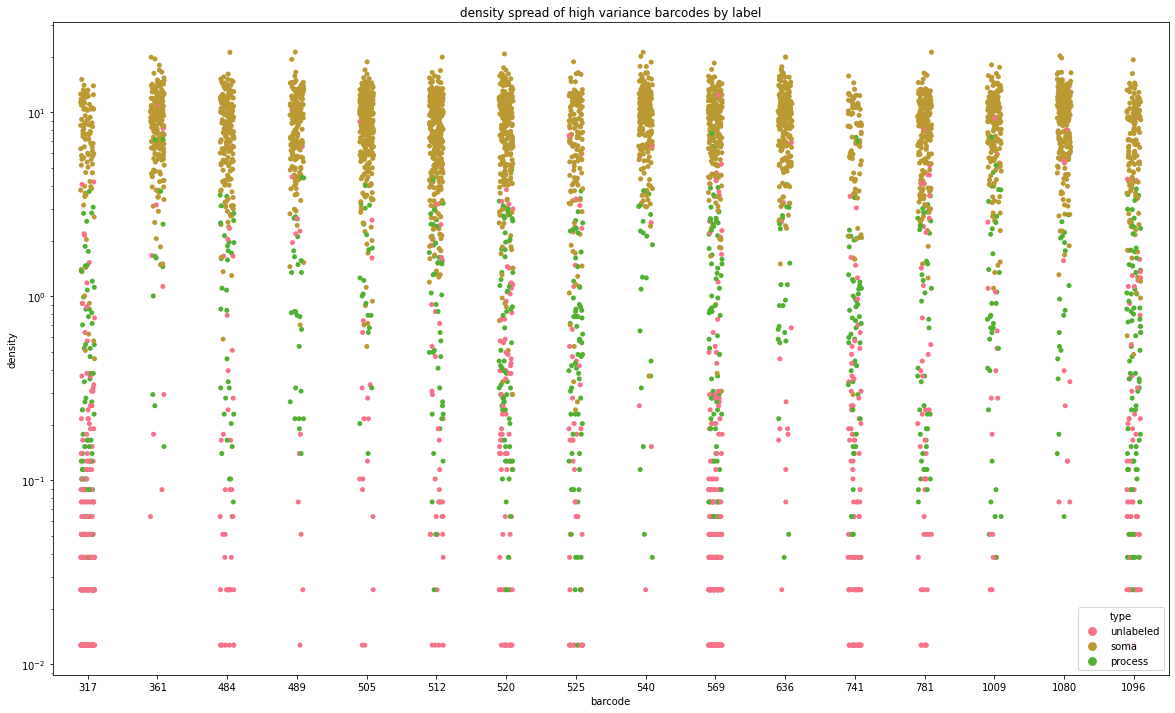

In [16]:
n = 16
high_var_codes = max_codes[:n]
high_var_samples = rna_subset_table[np.isin(rna_subset_table["barcode"], high_var_codes)]
fig, ax = plt.subplots(figsize = (20, 12))
sns.set_palette("husl")
ax.set_facecolor((0,0,0,0))
sns.stripplot(data=high_var_samples, y="density", x="barcode", hue="type", ax = ax)
ax.set_yscale('log')
ax.set_title("density spread of high variance barcodes by label")
plt.show()

# nrows = 4
# ncols = 4
# fig, axes = plt.subplots(nrows,ncols,figsize=(20,20))
# print(axes.shape)
# for i in range(nrows*ncols):
#     code = max_codes[i]
#     ax = axes[i // ncols, i % ncols]
#     sns.histplot(data=rna_subset_table[rna_subset_table["barcode"] == code], x="density", hue="type", kde=True, ax=ax)
#     ax.set_xlabel(f'{max_codes[i]}')
#
# plt.show()

## RCV Embedding

In [17]:
# n_genes = 1240
#
# # def get_rcv(point, k, tree: Qtree):
# #     vec = np.zeros(n_genes)
# #     neighbors = tree.get_nn(point, k, 40)
# #     ids = [int(neighbor.barcode) for neighbor in neighbors]
# #     for id in ids:
# #         vec[id] += 1
# #     return vec
#
# def get_rcvs(rna_vec, k, tree:Qtree):
#     rcvs = np.zeros((len(rna_vec), n_genes))
#     for i, pt in tqdm(enumerate(rna_vec)):
#         tree.get_nn(pt, k, 40, rcv=rcvs, id=i)
#
#     return rcvs
#
# n = 10000
#
# basis = np.random.choice(np.arange(len(rna_list)), n)
# rna_vec = [rna_list[i] for i in basis]
# rcv_vec = get_rcvs(rna_vec, 500, qtree)

In [18]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
#
# pca = PCA()
# pca.fit(rcv_vec)
# var = pca.explained_variance_
# embedded = pca.transform(rcv_vec)
# reducer = TSNE(n_components=3, init='pca')
# embedding = reducer.fit_transform(embedded[:,:15])
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(embedding[:,0], embedding[:,1], embedding[:,2])
# plt.show()

In [19]:
# def embed_rcv(rcv, pca:PCA, tsne:TSNE, tsne_fitted):
#     pca_reduced = pca.transform(rcv)
#     tsne_mapped = tsne.fit_transform(pca_reduced)
#     medians = np.median(np.abs(tsne_mapped), axis=0)
#     normed = np.clip(tsne_mapped/(2*medians), -1, 1)
#     return normed

## Generate Cell Species Image

In [224]:
class ColorByZ(basicrna.Colorizer):
    def get_color(self, pt):
        return pt.z

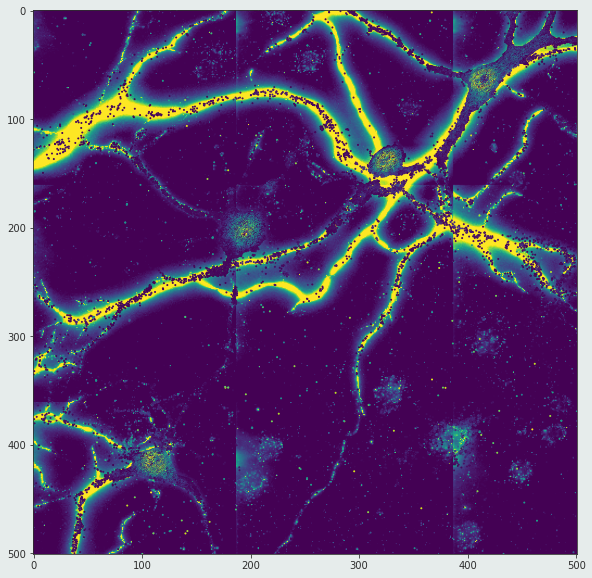

In [226]:
# rec = trees.Rect([250, 1024, 500, 500])
bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h+1, rec.x:rec.x+rec.w+1])

fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_facecolor('#e6eceb')
points = qtree.query(rec)
basicrna.plot_points(ax, points, colorizer=ColorByZ(), image=bgimage[:,:,2]/2, offset=(rec.y, rec.x))

plt.show()

## High Variance Barcodes Image

(4, 4)


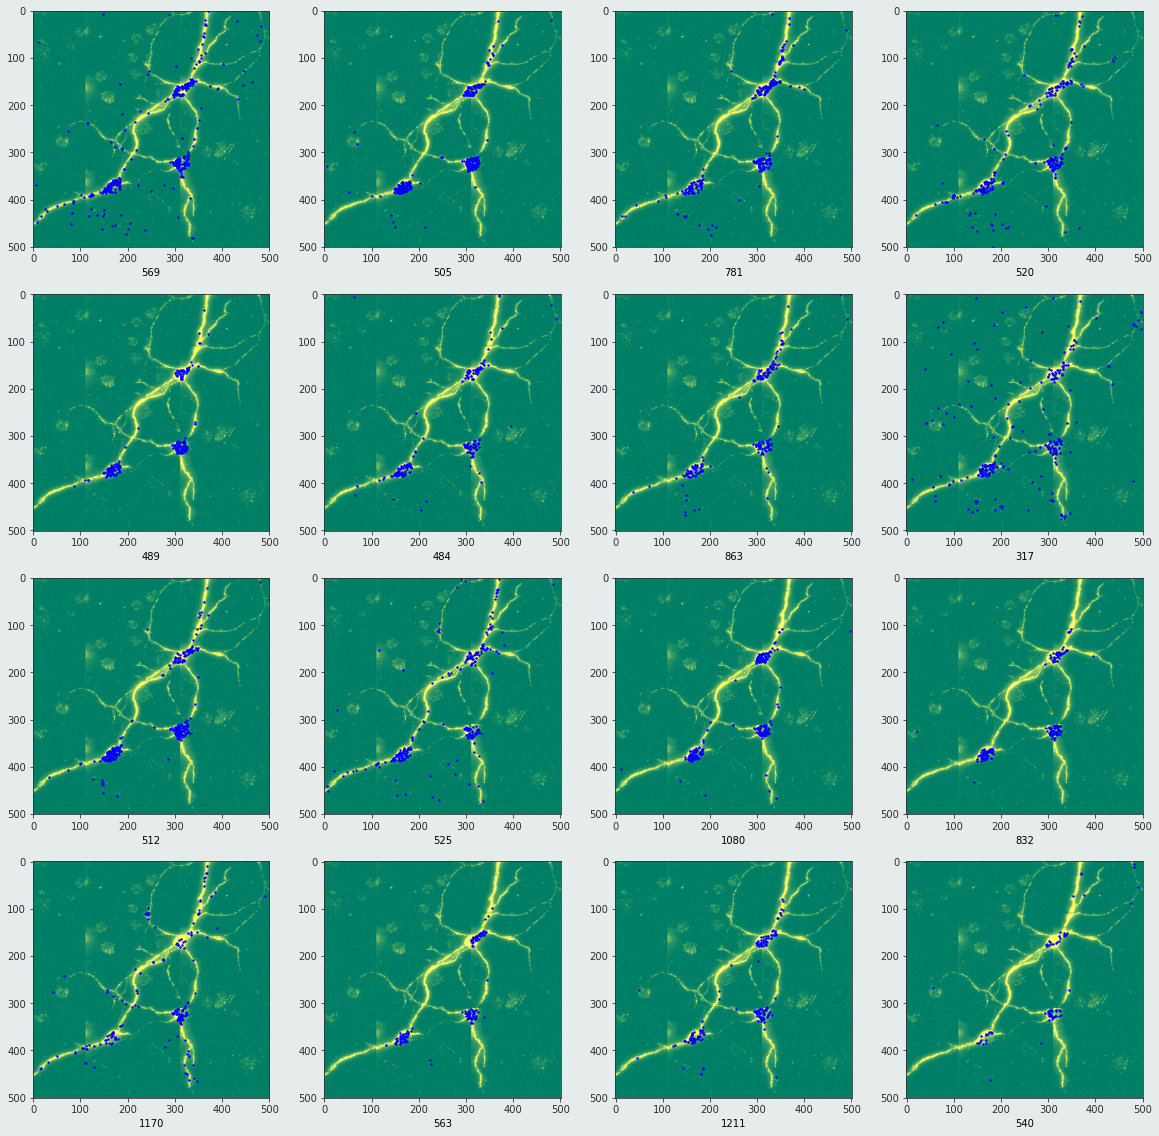

In [217]:
rec = trees.Rect([700, 700, 500, 500])
# bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h, rec.x:rec.x+rec.w])

nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows,ncols,figsize=(20,20))
print(axes.shape)
for i in range(nrows*ncols):
    tester = trees.BarcodeTester(max_codes[i])
    ax = axes[i//ncols][i%ncols]
    points = qtree.query(rec, tester=tester)
    basicrna.plot_points(ax, points, c='blue', s=2, image=bgimage[:,:,2], offset=(rec.y, rec.x), cmap="summer")
    ax.set_xlabel(f'{max_codes[i]}')

plt.show()

In [16]:
import importlib
importlib.reload(search)

<module 'search' from 'C:\\Lab Work\\segmentation\\Segmentation\\search.py'>

## Diffusion Experiment

### Build process and soma objects

In [23]:
# processes = branches.buildProcesses(processImage, RNA)
# somas = branches.buildSomas(somaImage, RNA)

In [24]:
# bbs = [[300,1000,500,500],[2500,2700,500,500]]
#
# baseimgfile = datapath+"preprocessed.png"
# baseimg = cv2.imread(baseimgfile)
#
# probimname = 'preprocessed_Probabilities.png'
# datafile = datapath + probimname
# segProbIm = cv2.imread(datafile)
#
# # plotting.embedimg(baseimg, bbs, plotpath)
# # plotting.embedimg(segProbIm, bbs, datapath, name="probabilities")
# # plotting.embedimg(processImage, bbs, datapath, name="processImg")

In [25]:
# for process in list(processes.values())[:20]:
#     neighbors = process.getNeighbors(somaImage, 'soma', 10)

In [26]:
# branch_list = []
# for process in list(processes.values())[:20]:
#     for soma in process.neighbors['soma']:
#         root = branches.Root(somas[soma])
#         branch_list.append(branches.Branch(root, process))
# branch_list[4].plot()

In [27]:
# plotting.implot(branch_list[4].disIm)

In [28]:
# for i, branch in enumerate(branch_list[:5]):
#     rnaids, rnadists = branch.get_rnadistances(True)
    # plotting.plotKDE(rnadists, "RNA distribution along candidate branch", savefile=datapath+f'rnabranch{i}.png')

In [29]:
# for branch in branch_list[:5]:
#     process = branch.end
#     soma = branch.source.end
    # print(process.ymin, process.xmin, process.label, process.neighbors)
    # print(soma.ymin, soma.xmin, soma.label)
    # plotting.implot(1*(processImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==process.label) + (somaImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==soma.label)*2, datapath, show=False)
    # plotting.implot((somaImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==soma.label)*2, datapath, show=False)
    # plt.show()

In [ ]:
# import pyro
# import pyro.distributions as dist
# import torch.distributions.constraints as constraints
# import torch
# from pyro.optim import Adam
# from pyro.infer import SVI, Trace_ELBO
#
# branch = branch_list[4]
#
# # clear the param store in case we're in a REPL
# pyro.clear_param_store()
#
# def model(data):
#     # beta = dist.Uniform('beta',low=torch.tensor(0.0), high=torch.tensor(1.0))
#     # sigma = dist.Bernoulli('sigma',p=beta)
#     lam_0 = pyro.sample('latent_rate', dist.Beta(torch.tensor([1.0]),torch.tensor([1.0])))
#     # x = dist.Uniform('x',np.min(branch.rnadists),np.max(branch.rnadists))
#     for i in range(len(data)):
#         x = pyro.sample(f'distance_{i}', dist.Exponential(lam_0), obs=data[i])
#
# def guide(data):
#     alpha_q = pyro.param("alpha_q", torch.tensor([1.0]), constraint=constraints.positive)
#     beta_q = pyro.param("beta_q", torch.tensor([1.0]), constraint=constraints.positive)
#     pyro.sample("latent_rate", dist.Beta(alpha_q,beta_q))
#
# # setup the optimizer
# adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
# optimizer = Adam(adam_params)
#
# # setup the inference algorithm
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
#
# data = torch.from_numpy(branch.rnadists)
# n_steps = 200
#
# # do gradient steps
# for step in range(n_steps):
#     svi.step(data)
#     if step % 20 == 0:
#         alpha = pyro.param("alpha_q").item()
#         beta = pyro.param("beta_q").item()
#         inferred_mean = alpha / (alpha + beta)
#         print(step, inferred_mean)

In [ ]:
# alpha = pyro.param("alpha_q").item()
# beta = pyro.param("beta_q").item()
# inferred_mean = alpha / (alpha + beta)
# print(1/inferred_mean)

In [ ]:
# print(alpha,beta)

In [ ]:
# import seaborn as sns

In [ ]:
# rate_dist = dist.Beta(alpha,beta)
# x = torch.tensor(np.arange(0.01,0.1,0.001))
# plt.plot(x,np.exp(rate_dist.log_prob(x)))
# plt.ylabel("P(lam|data)")
# plt.xlabel("lam")
# plt.title("Posterior Distribution of Rate Parameter")
# plt.show()
# x = torch.tensor(np.arange(1,220,1))
# plt.plot(x,np.exp(dist.Exponential(inferred_mean).log_prob(x)),label="P(x|lamda)")
# plt.plot(x,np.exp(dist.Exponential(1/np.mean(branch.rnadists)).log_prob(x)),label="MLE P(x|lamda)")
# sns.kdeplot(branch.rnadists, label="True distribution",bw_method=0.02)
# plt.xlabel("distance from soma (px)")
# plt.title("Exponential Fit to Data")
# plt.legend()
# plt.xlim(xmin=0)
# plt.show()

In [ ]:
# import pyro
# import pyro.distributions as dist
# import pyro.poutine as poutine
# from pyro.infer import MCMC, NUTS
#
# # pyro.set_rng_seed(0)
# pyro.clear_param_store()
#
# def model(data):
#     beta = pyro.param('prob_above',torch.tensor([0.5]),constraint=constraints.interval(0,1))
#     sigma = pyro.sample('bool_above', dist.Bernoulli(beta))
#
#     lam = pyro.param('latent_rate',torch.tensor([0.5]),constraint=constraints.positive)
#     delta = pyro.param('delta', dist.Exponential(lam))
#     x = pyro.sample("source", dist.Uniform(torch.tensor(data.min()),torch.tensor(data.max())))
#
#     position = (2*sigma - 1)*delta + x
#
#     i = np.random.randint(len(data))
#     pyro.sample('obs', dist.Normal(position, 0.05), obs=data[i])
#
# # def conditioned_model(model, sigma, y):
# #     return poutine.condition(model, data={"obs": y})(sigma)
#
# nuts_kernel = NUTS(model)
# mcmc = MCMC(
#     nuts_kernel,
#     num_samples=1000,
#     num_chains=1,
# )
#
# data = torch.from_numpy(branch.rnadists)
#
# mcmc.run(data)
# mcmc.summary(prob=0.5)